# Greenhouse gas benefit from underplanting wildfire-impacted forest stands

Robbie A Hember, PhD, P.Ag.

Last updated: 2020-03-17

Climate Change and Integrated Planning Branch,<br>
Office of the Chief Forester,<br>
Forests Lands, Natural Resource Operations and Rural Development<br>
Government of British Columbia<br>
545 Superior Street, Victoria, Canada<br>
robert.hember@gov.bc.ca

## Introduction

Reforestation of stands that are damaged by wildfires is a major component of land use plans throughout many parts of British Columbia. There are several methods of reforestation, including salvage logging, knock down, underplanting, and natural regeneration. Underplanting refers to planting areas that require no removal of the overstory. It is primarily applied where the overstory is nearly or completely dead, and where seed rain is weak or obstructed following high-severity wildfires (see [FCI reforestation](https://www2.gov.bc.ca/assets/gov/environment/natural-resource-stewardship/nrs-climate-change/mitigation/forest-carbon-initiative/module_3_reforestation_web.pdf)).

Consistent with other climate change mitigation activities, the greenhouse gas (GHG) benefit is assessed from the difference between the GHG balance of the treatment area for a baseline scenario (where the project is not undertaken), and a project scenario (where underplanting is implemented). A positive value of GHG benefit (i.e., the GHG balance of the project scenario is greater than that of the baseline scenario) indicates that the project reduces the atmospheric concentration of GHGs. 

In this study, we estimate the GHG benefit from demonstrative examples of the underplanting project type in interior and coastal regions of British Columbia, Canada. 

![Trees](https://4cvdc442sefv2px6qf31zwhf-wpengine.netdna-ssl.com/wp-content/uploads/2019/04/16291002_web1_190410-WLT-ForestEnhancementFunding.jpg)
Stands damaged by wildfire in 100 Mile House (www.quesnelobserver.com/news/forest-enhancement-bc-allocates-another-3-4-million-to-improve-damaged-forests/).

## Assumptions

In each regional example stand, we assume that a severe wildfire occurred in 2017, leading to 100 percent mortality.

For the interior region, we will assume that the pre-wildfire stand was 100 percent lodgepole pine with a clumped distribution, site index (SI) of 18 m, and stand density of 1600 stems/hectare. We will assume that the stand was 120 years old when the wildfire occurred in 2017. We will assume that the 2017 wildfire killed 100% of the trees.

As natural regeneration in the baseline scenario is uncertain, we will consider 3 scenarios (1 project and 2 baselines that reflect different levels of natural regeneration):

    1) Baseline scenario - satisfactorily restrocked (SR): 100% lodgepole pine, SI=18 m, N=1800 stems/ha, spatial arrangement=clumped, regen. delay=2 years

    2) Baseline scenario - non-satisfactorily restrocked (NSR): 100% lodgepole pine, SI=18 m, N=200 stems/ha, spatial arrangement=clumped, regen. delay=5 years

    3) Project scenario: 100% lodgepole pine, SI=18 m, N=1800 stems/ha, spatial arrangement=planted, regen. delay=0 years.

For the coastal region, we will assume that the pre-wildfire stand was 100 percent coastal Douglas-fir, natural spatial arrangement, SI = 30 m, and a stand density of 1600 stems/ha. We will assume that the 2017 wildfire killed 100% of the trees. The same 3 types of scenarios will be considered on the coast:

    1) Baseline scenario - satisfactorily restrocked (SR): 100% Douglas-fir, SI=30 m, N=1600 stems/ha, spatial arrangement=natural, regen. delay=2 years

    2) Baseline scenario - non-satisfactorily restrocked (NSR): 100% Douglas-fir, SI=30 m, N=200 stems/ha, spatial arrangement=natural, regen. delay=5 years

    3) Project scenario: 100% Douglas-fir, SI=30 m, N=1600 stems/ha, spatial arrangement=planted, regen. delay=0 years.

There is a signficant chance that these stands will experience more natural disturbances in the future. Assuming that the stands will again experience wildfire in a specific year, say 2042 or 2096, is subjective. Instead, we will represent future disturbance based on simulations that assume a constant annual probability of wildfire. For the interior stand, we will assume a wildfire return interval of 100 years, while in the coastal stand, we will assume a wildfire return interval of 200 years. 

## Set up and run the simulation

Use this button to show or hide the underlying Python code.

In [1]:
from IPython.core.display import display, HTML
HTML('''<script>
code_show=false; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show(); }
 code_show = !code_show} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Show/hide code"></form>''')

Prepare the session in this Jupyter Notebook by importing the required python packages and graphics parameters.

In [2]:
# Import modules
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
from fcgadgets.utilities import utilities_general as gu
from fcgadgets.utilities import utilities_gis as gis
from fcgadgets.cbrunner import cbrun_utilities as cbu
from fcgadgets.cbrunner import cbrun as cbr
# Turn warnings off
warnings.filterwarnings('ignore')
# Graphic display parameters
%matplotlib inline
plt.style.use('ggplot')
display(HTML("<style>.container { width:80% !important; } .output {align-items: left; }</style>"))

In [3]:
# Import graphics parameters specifically for FCI demos
params_graphic=cbu.Import_GraphicsParameters('FCI Demo')
plt.rcParams.update(params_graphic)

Open <i>ProjectConfig.xlsx</i> and set project-specific parameters. Specify the desired timeframe of the simulation. Set the "Biomass Module" parameter to "TIPSY" so that the TASS/TIPSY growth and yield modelling framework will be used to drive stand biomass dynamics. Assume a pre-industrial disturbance regime defined by wildfire and a constant return interval of 150 years. As we will consider the impact of future disturbances, set the number of ensembles, "N Ensemble" to 600.

Under the "Scenario Parameters" section, set scenario assumptions, including the chronology of disturbance and management events that occur in each scenario. Each disturbance or management event is accompanied by a specific growth curve identifier (ID) that will specify the stand conditions for the regenerating stand that follows the event. Specify the return interval of future wildfires under the "Distrubance from Simulation (Future)" section of the "Scenario Parameters" section of <i>ProjectConfig.xlsx</i>. Simulation of future disturbances based on probability introduces a random component to the results. To distinguish the signal from random variability, we will perform the simulations for each scenario multiple times (i.e., 600 ensembles) and then take the average of the ensembles as the final best estimate.

Open the <i>GrowthCurvesTIPSY_Parameters.xlsx</i> file and set TIPSY input parameters for each combination of scenario ID and growth curve ID that has been listed in the Disturbance/Management chronology in <i>ProjectConfig.xlsx</i>.

Import project parameters, scenario parameters, and growth curve parameters.

In [4]:
meta={}
meta['Paths']={}
meta['Paths']['Project']=r'G:\My Drive\Data\FCI_Demo_ReforestationUnderplantingWildfire'
meta['Paths']['Model Code']=r'C:\Users\rhember\Documents\Code_Python\fcgadgets\cbrunner'
meta=cbu.ImportProjectConfig(meta)

OSError: [Errno 22] Invalid argument: 'G:\\My Drive\\Data\\FCI_Demo_ReforestationUnderplantingWildfire\\Inputs\\ProjectConfig.xlsx'

Use the method, <i>cbrun_utilities.Write_BatchTIPSY_Input_File</i>, to convert the parameters in <i>GrowthCurvesTIPSY_Parameters.xlsx</i> to a file that is readable by BatchTIPSY.exe.

In [5]:
cbu.Write_BatchTIPSY_Input_File(meta)

Open <i>GrowthCurvesTIPSY_Output.BTP</i> using BatchTIPSY.exe application, verify that settings have been specified properly, and run BatchTIPSY.exe to produce the growth curves.

Prepare the inventory file.

In [6]:
cbu.PrepareInventory(meta)

Prepare the disturbance/management event chronology file.

In [7]:
cbu.BuildEventChronologyFromSpreadsheet(meta)

Convert the output files from BatchTIPSY.exe into a usable format.

In [8]:
cbu.PostProcessBatchTIPSY(meta)

Run the simulation.

In [9]:
cbr.MeepMeep(meta)

Running Scenario 0001, Ensemble 0001, Batch 0001
0.7539851665496826
Running Scenario 0002, Ensemble 0001, Batch 0001
0.731593132019043
Running Scenario 0003, Ensemble 0001, Batch 0001
0.7309272289276123
Running Scenario 0004, Ensemble 0001, Batch 0001
0.7327828407287598
Running Scenario 0005, Ensemble 0001, Batch 0001
0.7754371166229248
Running Scenario 0006, Ensemble 0001, Batch 0001
0.7430143356323242


Load the results.

In [10]:
meta=gu.ipickle(meta['Paths']['Project'] + '\\Inputs\\Metadata.pkl')
v1,meta=cbu.LoadScenarioResults(meta,[0,1,2,3,4,5])
v2,meta=cbu.CalculateGHGBalance(v1,meta)
gc=cbu.Import_BatchTIPSY_Output(meta)

## Results

Ensure that a suffient number of ensembles were included. Recall that we ran 600 ensemble simulations so that we would be able to calculate a smooth average GHG benefit from the full set of ensembles. If we consider too few ensembles, the resulting GHG benefit estimate may be unduely representative of random variation. Let's draw from the results at differnet sampling rates to understand how 600 ensembles affect the final result for the interior site with the NSR baseline assumption.

In [11]:
flg=0
if flg==1:
    N=np.arange(10,600,10)
    N_iter=100
    it=np.where(v2[0].Year==2050)[0]
    y=np.zeros((N.size,N_iter))
    for i in range(N_iter):
        for j in range(N.size):
            r=np.random.random((600,1))
            idx=np.argsort(r,axis=0)
            ikp=np.where(idx<=N[j])[0]
            ghgb_ann=np.mean(v2[2].Sec_NGHGB[:,ikp],axis=1)-np.mean(v2[1].Sec_NGHGB[:,ikp],axis=1)
            ghgb_c=np.cumsum(ghgb_ann)
            y[j,i]=ghgb_c[it]
    y=np.mean(y,axis=1)
    fig,ax=plt.subplots(1,figsize=gu.cm2inch(18,7))
    ax.plot(N,np.abs(y-np.mean(y)),'-ko',markersize=3,linewidth=0.5)
    ax.set(ylabel='Absolute error (tCO2e/ha)',
           xlabel='Number of ensemble projections');
    fig.suptitle('Figure 1. Impact of number of ensembles on variation in GHG benefit by 2050.');

By plotting error variance against number of ensembles, we can see that running 600 ensembles will allow us to estimate cumulative 2050 GHG benefit with a precision of roughly 0.25 tCO2e/ha. As such, we are satisfied that this was a suffient number of ensembles to represent impacts of future wildfires.

Specify the time period to focus on.

In [12]:
it=np.where(v2[0].Year>1950)[0]

Plot time series of carbon pools for each scenario.

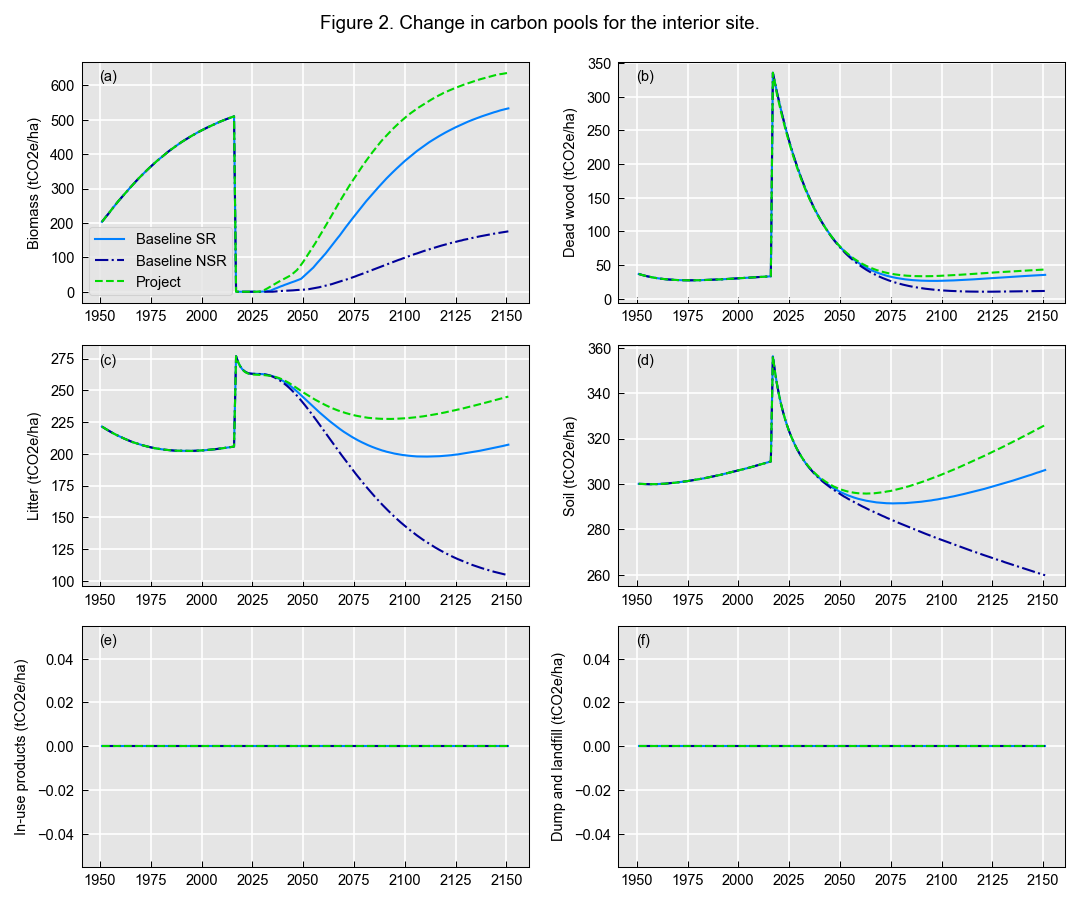

In [13]:
str_var=['Eco_Biomass','Eco_DeadWood','Eco_Litter','Eco_Soil','Pro_InUse','Pro_DumpLandfill']
cnt=0
fig,ax=plt.subplots(3,2,figsize=gu.cm2inch(18,15))
for i in range(3):
    for j in range(2):
        ax[i,j].plot(v2[0].Year[it],np.mean(v2[0][str_var[cnt]][it,:],axis=1),'-',color=(0,0.5,1), \
                     linewidth=1,label='Baseline SR')
        ax[i,j].plot(v2[1].Year[it],np.mean(v2[1][str_var[cnt]][it,:],axis=1),'-.',color=(0,0,0.6), \
                     linewidth=1,label='Baseline NSR')
        ax[i,j].plot(v2[2].Year[it],np.mean(v2[2][str_var[cnt]][it,:],axis=1),'--',color=(0,0.85,0), \
                     linewidth=1,label='Project')
        if (i==0) & (j==0):
            ax[i,j].legend(loc="lower left")
        ax[i,j].set(ylabel=meta['Labels GHG Balance'][str_var[cnt]])
        cnt=cnt+1
fig.suptitle('Figure 2. Change in carbon pools for the interior site.')
gu.axletters(ax,plt,0.04,0.92)

Plot time series of carbon fluxes for each scenario.

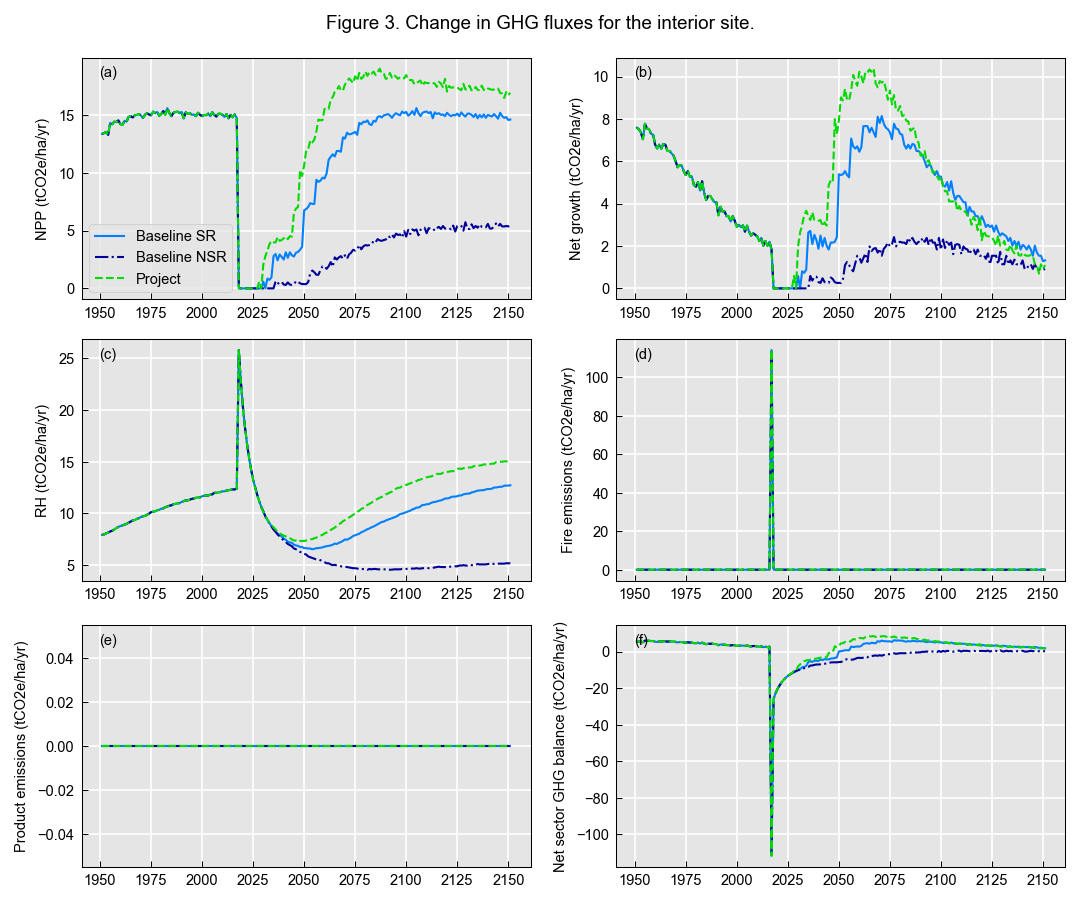

In [14]:
for i in range(len(v2)):
    v2[i].Eco_NEP=v2[i].Eco_NPP-v2[i].Eco_RH
    v2[i].Eco_E_Fire=v2[i].Eco_E_Wildfire+v2[i].Eco_E_OpenBurning
str_var=['Eco_NPP','Eco_G_Net','Eco_RH','Eco_E_Fire','Pro_Emissions','Sec_NGHGB']
cnt=0
fig,ax=plt.subplots(3,2,figsize=gu.cm2inch(18,15))
for i in range(3):
    for j in range(2):
        ax[i,j].plot(v2[0].Year[it],np.mean(v2[0][str_var[cnt]][it,:],axis=1),'-',color=(0,0.5,1), \
                     linewidth=1,label='Baseline SR')
        ax[i,j].plot(v2[1].Year[it],np.mean(v2[1][str_var[cnt]][it,:],axis=1),'-.',color=(0,0,0.6), \
                     linewidth=1,label='Baseline NSR')
        ax[i,j].plot(v2[2].Year[it],np.mean(v2[2][str_var[cnt]][it,:],axis=1),'--',color=(0,0.85,0), \
                     linewidth=1,label='Project')
        if (i==0) & (j==0):
            ax[i,j].legend(loc="lower left")
        try:
            ax[i,j].set(ylabel=meta['Labels GHG Balance'][str_var[cnt]])
        except:
            ax[i,j].set(ylabel='Fire emissions (tCO2e/ha/yr)')    
        cnt=cnt+1
fig.suptitle('Figure 3. Change in GHG fluxes for the interior site.')
gu.axletters(ax,plt,0.04,0.92)

Plot time series of net ecosystem production (i.e., photosynthesis minus respiration).

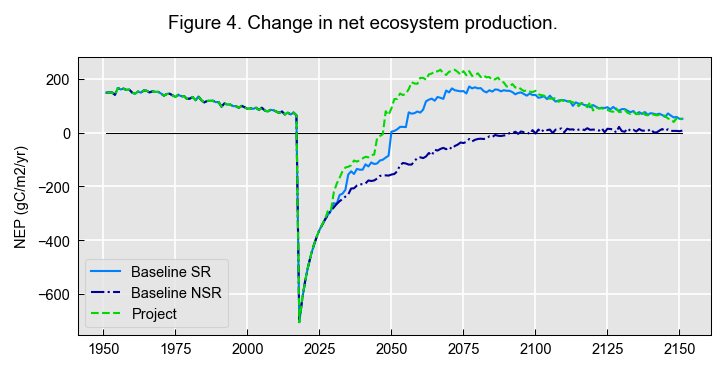

In [15]:
cnt=0
fig,ax=plt.subplots(1,figsize=gu.cm2inch(12,6))
ax.plot(v2[0].Year[it],0*np.ones(v2[0].Year[it].shape),'-',linewidth=0.5,color=(0,0,0))
ax.plot(v2[0].Year[it],np.mean(v2[0]['Eco_NPP'][it,:]-v2[0]['Eco_RH'][it,:],axis=1)/3.667*100,'-', \
        color=(0,0.5,1),linewidth=1,label='Baseline SR')
ax.plot(v2[1].Year[it],np.mean(v2[1]['Eco_NPP'][it,:]-v2[1]['Eco_RH'][it,:],axis=1)/3.667*100,'-.', \
        color=(0,0,0.6),linewidth=1,label='Baseline NSR')
ax.plot(v2[2].Year[it],np.mean(v2[2]['Eco_NPP'][it,:]-v2[2]['Eco_RH'][it,:],axis=1)/3.667*100,'--', \
        color=(0,0.85,0),linewidth=1,label='Project')
ax.legend(loc="lower left")
ax.set(ylabel='NEP (gC/m2/yr)')
fig.suptitle('Figure 4. Change in net ecosystem production.');

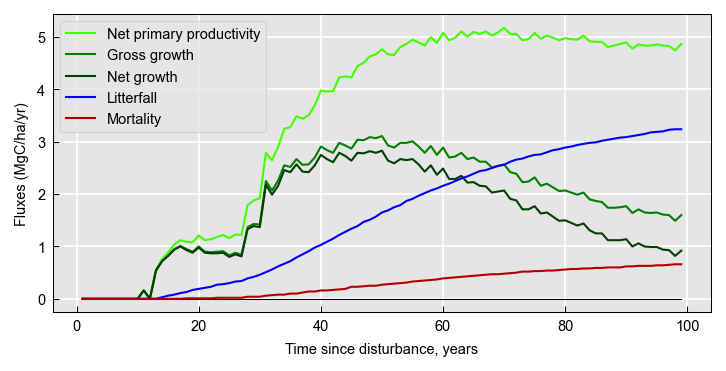

In [16]:
it=np.where( (v1[2].Year>=2018) & (v1[2].Year<=2116) )[0]
fig,ax=plt.subplots(1,figsize=gu.cm2inch(12,6))
ax.plot(v1[2].Year[it]-2017,0*np.ones(v2[0].Year[it].shape),'-',linewidth=0.5,color=(0,0,0))
ax.plot(v1[2].Year[it]-2017,np.sum(v1[2]['C_NPP'][it,0,:],axis=1),'-',color=(0.25,1,0),linewidth=1,label='Net primary productivity')
ax.plot(v1[2].Year[it]-2017,np.sum(v1[2]['C_G_Gross'][it,0,:],axis=1),'-',color=(0,0.5,0),linewidth=1,label='Gross growth')
ax.plot(v1[2].Year[it]-2017,np.sum(v1[2]['C_G_Net'][it,0,:],axis=1),'-',color=(0,0.25,0),linewidth=1,label='Net growth')
ax.plot(v1[2].Year[it]-2017,np.sum(v1[2]['C_LF'][it,0,:],axis=1),'-',color=(0,0,1),linewidth=1,label='Litterfall')
ax.plot(v1[2].Year[it]-2017,np.sum(v1[2]['C_M_Reg'][it,0,:],axis=1),'-',color=(0.7,0,0),linewidth=1,label='Mortality')
ax.legend(loc="upp left");
ax.set(ylabel='Fluxes (MgC/ha/yr)',xlabel='Time since disturbance, years');
#fig.suptitle('Figure 4. Change in net ecosystem production.');

Plot net sector GHG balance for each scenario and GHG benefit (i.e., the difference in GHG balance between scenarios).

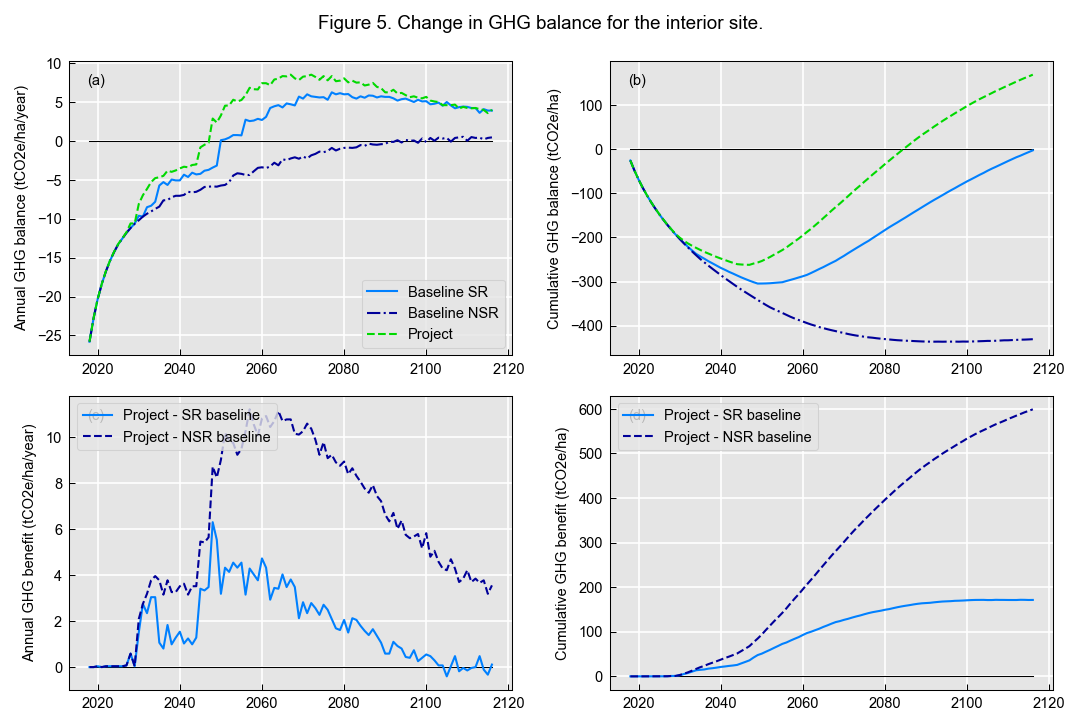

In [19]:
fig,ax=plt.subplots(2,2,figsize=gu.cm2inch(18,12))
ax[0,0].plot(v2[0].Year[it],0*np.ones(v2[0].Year[it].shape),'-',linewidth=0.5,color=(0,0,0))
ax[0,0].plot(v2[0].Year[it],np.mean(v2[0].Sec_NGHGB[it,:],axis=1),'-',color=(0,0.5,1),label='Baseline SR')
ax[0,0].plot(v2[0].Year[it],np.mean(v2[1].Sec_NGHGB[it,:],axis=1),'-.',color=(0,0,0.6),label='Baseline NSR')
ax[0,0].plot(v2[0].Year[it],np.mean(v2[2].Sec_NGHGB[it,:],axis=1),'--',color=(0,0.85,0),label='Project')
ax[0,0].legend(loc="lower right")
ax[0,0].set(ylabel='Annual GHG balance (tCO2e/ha/year)');
ax[0,1].plot(v2[0].Year[it],0*np.ones(v2[0].Year[it].shape),'-',linewidth=0.5,color=(0,0,0))
ax[0,1].plot(v2[0].Year[it],np.cumsum(np.mean(v2[0].Sec_NGHGB[it,:],axis=1)),'-',color=(0,0.5,1), \
             label='Baseline SR')
ax[0,1].plot(v2[0].Year[it],np.cumsum(np.mean(v2[1].Sec_NGHGB[it,:],axis=1)),'-.',color=(0,0,0.6), \
             label='Baseline NSR')
ax[0,1].plot(v2[0].Year[it],np.cumsum(np.mean(v2[2].Sec_NGHGB[it,:],axis=1)),'--',color=(0,0.85,0), \
             label='Project')
ax[0,1].set(ylabel='Cumulative GHG balance (tCO2e/ha)');
ax[1,0].plot(v2[0].Year[it],0*np.ones(v2[0].Year[it].shape),'-',linewidth=0.5,color=(0,0,0))
ax[1,0].plot(v2[0].Year[it],np.mean(v2[2].Sec_NGHGB[it,:]-v2[0].Sec_NGHGB[it,:],axis=1),'-', \
             color=(0,0.5,1),label='Project - SR baseline')
ax[1,0].plot(v2[0].Year[it],np.mean(v2[2].Sec_NGHGB[it,:]-v2[1].Sec_NGHGB[it,:],axis=1),'--', \
             color=(0,0,0.6),label='Project - NSR baseline')
ax[1,0].legend(loc="upper left")
ax[1,0].set(ylabel='Annual GHG benefit (tCO2e/ha/year)');
ax[1,1].plot(v2[0].Year[it],0*np.ones(v2[0].Year[it].shape),'-',linewidth=0.5,color=(0,0,0))
y=np.cumsum(np.mean(v2[2].Sec_NGHGB[it,:],axis=1))-np.cumsum(np.mean(v2[0].Sec_NGHGB[it,:],axis=1))
ax[1,1].plot(v2[0].Year[it],y,'-',color=(0,0.5,1),label='Project - SR baseline')
y=np.cumsum(np.mean(v2[2].Sec_NGHGB[it,:],axis=1))-np.cumsum(np.mean(v2[1].Sec_NGHGB[it,:],axis=1))
ax[1,1].plot(v2[0].Year[it],y,'--',color=(0,0,0.6),label='Project - NSR baseline')
ax[1,1].legend(loc="upper left")
ax[1,1].set(ylabel='Cumulative GHG benefit (tCO2e/ha)');
fig.suptitle('Figure 5. Change in GHG balance for the interior site.')
gu.axletters(ax,plt,0.04,0.92)

Put results in tabular format.

In [20]:
df=pd.DataFrame(columns=['Region','Baseline N','Ann. GHG benefit 2030 (tCO2e/ha/yr)', \
                         'Cumu. GHG benefit 2030 (tCO2e/ha)','Ann. GHG benefit 2050 (tCO2e/ha/yr)', \
                         'Cumu. GHG benefit 2050 (tCO2e/ha)','Ann. GHG benefit 2080 (tCO2e/ha/yr)', \
                         'Cumu. GHG benefit 2080 (tCO2e/ha)','Cost ($/ha)','Mitigation Cost ($/tCO2e)'])
df['Region']=['Interior','Interior','Coast','Coast']
df['Baseline N']=['SR','NSR','SR','NSR']

it1=np.where(v2[0].Year==2030)[0];
it2=np.where(v2[0].Year==2050)[0];
it3=np.where(v2[0].Year==2080)[0];

# Interior SR
cnt=0
dA=np.mean(v2[2].Sec_NGHGB-v2[0].Sec_NGHGB,axis=1)
dC=np.cumsum(np.mean(v2[2].Sec_NGHGB-v2[0].Sec_NGHGB,axis=1))
Cost=1800*1.0
dA30=dA[it1][0]; dC30=dC[it1][0]
dA50=dA[it2][0]; dC50=dC[it2][0]
dA80=dA[it3][0]; dC80=dC[it3][0]
df['Ann. GHG benefit 2030 (tCO2e/ha/yr)'].iloc[cnt]=np.round(dA30,decimals=1)
df['Cumu. GHG benefit 2030 (tCO2e/ha)'].iloc[cnt]=np.round(dC30,decimals=1)
df['Ann. GHG benefit 2050 (tCO2e/ha/yr)'].iloc[cnt]=np.round(dA50,decimals=1)
df['Cumu. GHG benefit 2050 (tCO2e/ha)'].iloc[cnt]=np.round(dC50,decimals=1)
df['Ann. GHG benefit 2080 (tCO2e/ha/yr)'].iloc[cnt]=np.round(dA80,decimals=1)
df['Cumu. GHG benefit 2080 (tCO2e/ha)'].iloc[cnt]=np.round(dC80,decimals=1)
df['Cost ($/ha)'].iloc[cnt]=np.round(Cost,decimals=0)
y=np.round(df['Cost ($/ha)'].iloc[cnt]/df['Cumu. GHG benefit 2050 (tCO2e/ha)'].iloc[cnt],decimals=0)
df['Mitigation Cost ($/tCO2e)'].iloc[cnt]=y
cnt=cnt+1

# Interior NSR
dA=np.mean(v2[2].Sec_NGHGB-v2[1].Sec_NGHGB,axis=1)
dC=np.cumsum(np.mean(v2[2].Sec_NGHGB-v2[1].Sec_NGHGB,axis=1))
dA30=dA[it1][0]; dC30=dC[it1][0]
dA50=dA[it2][0]; dC50=dC[it2][0]
dA80=dA[it3][0]; dC80=dC[it3][0]
Cost=1800*1.0
df['Ann. GHG benefit 2030 (tCO2e/ha/yr)'].iloc[cnt]=np.round(dA30,decimals=1)
df['Cumu. GHG benefit 2030 (tCO2e/ha)'].iloc[cnt]=np.round(dC30,decimals=1)
df['Ann. GHG benefit 2050 (tCO2e/ha/yr)'].iloc[cnt]=np.round(dA50,decimals=1)
df['Cumu. GHG benefit 2050 (tCO2e/ha)'].iloc[cnt]=np.round(dC50,decimals=1)
df['Ann. GHG benefit 2080 (tCO2e/ha/yr)'].iloc[cnt]=np.round(dA80,decimals=1)
df['Cumu. GHG benefit 2080 (tCO2e/ha)'].iloc[cnt]=np.round(dC80,decimals=1)
df['Cost ($/ha)'].iloc[cnt]=np.round(Cost,decimals=0)
y=np.round(df['Cost ($/ha)'].iloc[cnt]/df['Cumu. GHG benefit 2050 (tCO2e/ha)'].iloc[cnt],decimals=0)
df['Mitigation Cost ($/tCO2e)'].iloc[cnt]=y
cnt=cnt+1

# Coast SR
dA=np.mean(v2[5].Sec_NGHGB-v2[3].Sec_NGHGB,axis=1)
dC=np.cumsum(np.mean(v2[5].Sec_NGHGB-v2[3].Sec_NGHGB,axis=1))
dA30=dA[it1][0]; dC30=dC[it1][0]
dA50=dA[it2][0]; dC50=dC[it2][0]
dA80=dA[it3][0]; dC80=dC[it3][0]
Cost=1800*1.3
df['Ann. GHG benefit 2030 (tCO2e/ha/yr)'].iloc[cnt]=np.round(dA30,decimals=1)
df['Cumu. GHG benefit 2030 (tCO2e/ha)'].iloc[cnt]=np.round(dC30,decimals=1)
df['Ann. GHG benefit 2050 (tCO2e/ha/yr)'].iloc[cnt]=np.round(dA50,decimals=1)
df['Cumu. GHG benefit 2050 (tCO2e/ha)'].iloc[cnt]=np.round(dC50,decimals=1)
df['Ann. GHG benefit 2080 (tCO2e/ha/yr)'].iloc[cnt]=np.round(dA80,decimals=1)
df['Cumu. GHG benefit 2080 (tCO2e/ha)'].iloc[cnt]=np.round(dC80,decimals=1)
df['Cost ($/ha)'].iloc[cnt]=np.round(Cost,decimals=0)
y=np.round(df['Cost ($/ha)'].iloc[cnt]/df['Cumu. GHG benefit 2050 (tCO2e/ha)'].iloc[cnt],decimals=0)
df['Mitigation Cost ($/tCO2e)'].iloc[cnt]=y
cnt=cnt+1

# Coast NSR
dA=np.mean(v2[5].Sec_NGHGB-v2[4].Sec_NGHGB,axis=1)
dC=np.cumsum(np.mean(v2[5].Sec_NGHGB-v2[4].Sec_NGHGB,axis=1))
dA30=dA[it1][0]; dC30=dC[it1][0]
dA50=dA[it2][0]; dC50=dC[it2][0]
dA80=dA[it3][0]; dC80=dC[it3][0]
Cost=1800*1.3
df['Ann. GHG benefit 2030 (tCO2e/ha/yr)'].iloc[cnt]=np.round(dA30,decimals=1)
df['Cumu. GHG benefit 2030 (tCO2e/ha)'].iloc[cnt]=np.round(dC30,decimals=1)
df['Ann. GHG benefit 2050 (tCO2e/ha/yr)'].iloc[cnt]=np.round(dA50,decimals=1)
df['Cumu. GHG benefit 2050 (tCO2e/ha)'].iloc[cnt]=np.round(dC50,decimals=1)
df['Ann. GHG benefit 2080 (tCO2e/ha/yr)'].iloc[cnt]=np.round(dA80,decimals=1)
df['Cumu. GHG benefit 2080 (tCO2e/ha)'].iloc[cnt]=np.round(dC80,decimals=1)
df['Cost ($/ha)'].iloc[cnt]=np.round(Cost,decimals=0)
y=np.round(df['Cost ($/ha)'].iloc[cnt]/df['Cumu. GHG benefit 2050 (tCO2e/ha)'].iloc[cnt],decimals=0)
df['Mitigation Cost ($/tCO2e)'].iloc[cnt]=y
cnt=cnt+1
df

,Region,Baseline N,Ann. GHG benefit 2030 (tCO2e/ha/yr),Cumu. GHG benefit 2030 (tCO2e/ha),Ann. GHG benefit 2050 (tCO2e/ha/yr),Cumu. GHG benefit 2050 (tCO2e/ha),Ann. GHG benefit 2080 (tCO2e/ha/yr),Cumu. GHG benefit 2080 (tCO2e/ha),Cost ($/ha),Mitigation Cost ($/tCO2e)
0,Interior,SR,1.5,2.4,3.2,50.9,2.1,149.3,1800,35
1,Interior,NSR,2.1,3,9,93.8,8.9,396.2,1800,19
2,Coast,SR,2.4,5.7,2.2,162.5,-1.5,189,2340,14
3,Coast,NSR,2.4,5.7,19.1,318.6,5.9,677,2340,7


In [21]:
it=np.where( (v1[0]['Year']>=1990) & (v1[0]['Year']<=2100) )[0] 
dA=np.column_stack( (v1[0]['Year'][it],np.mean(v2[0].Sec_NGHGB[it,:],axis=1),np.mean(v2[1].Sec_NGHGB[it,:],axis=1),np.mean(v2[2].Sec_NGHGB[it,:],axis=1)) )
print(dA.shape)
df=pd.DataFrame(dA)
#dA.tofile(r'C:\Users\rhember\Downloads\Underplanting\out.csv',',')
df.to_excel(r'C:\Users\rhember\Downloads\Underplanting\out.xlsx')

(111, 4)


## Acknowledgements

This work was supported by Canada's Low Carbon Economy Leadership Fund (https://www.canada.ca/en/environment-climate-change/services/climate-change/low-carbon-economy-fund.html).